In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Activation

from sklearn.model_selection import train_test_split

print("Done!")


2024-07-04 14:46:18.232516: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 14:46:18.269645: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 14:46:18.477725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 14:46:20.746909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Done!


In [11]:
"""display function"""
#This function is for displaying 2 waveforms on top of each other
#it is used to compare clean and noisy waveforms, or trained and clean waveforms

def display_n_plots_format2(t_axis,data,n,m,wave_2=None, c=1, Mode=0):
    print("--------------------------------------------------------")

    if Mode!=False:

        for i in range(n):
            exec(f'SecondWave{i+1}=np.array([])')
        for i in range(100):
            for j in range(n):
                exec(f'SecondWave{j+1}=np.append(SecondWave{j+1}, wave_2[{m}][{i}][{j}])')
        SecondWaves=[]
        for i in range(n):
            exec (f'SecondWaves.append(SecondWave{i+1})')

    for i in range(n):
        exec(f'Channel{i+1}=np.array([])')
    for i in range(100):
        for j in range(n):
            exec(f'Channel{j+1}=np.append(Channel{j+1}, data[{m}][{i}][{j}])')
    Channels=[]
    for i in range(n):
        exec (f'Channels.append(Channel{i+1})')



    fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # Adjust the figure size
    y_limits = (-250, 250)
    for i, ax in enumerate(axs.flat):
        ax.plot(t_axis, c * Channels[i], lw=2, alpha=0.7, label="Real_signal")

        if Mode!=False:
            ax.plot(t_axis, c * SecondWaves[i], lw=1.5, alpha=0.9, label="Predicted_signal")

        ax.set_title(f'Channel {i + 1}', fontsize=10)

        ax.set_ylim(y_limits)
        ax.grid(True, lw=0.5)
        ax.label_outer()  # Only show outer labels to avoid redundancy

    plt.legend()
    fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title
    plt.show()

    """
    plt.savefig(f'plot_n_{m}')
    plt.clf()
    """
print("Done!")

Done!


In [4]:
#Imports the simulated data

training_data=pd.read_pickle("training_data_High_Amplitude.pkl")
real_data=pd.read_pickle("real_data_High_Amplitude.pkl")

noisy_test=pd.read_pickle("Test_data_High_Amplitude.pkl")
real_test=pd.read_pickle("Test_real_High_Amplitude.pkl")

print("Done!")

Done!


In [5]:
"""defines the function that reshapes the data to fit the CNN and defines the parameters that match the size of the simulations and the desired output shape"""

Params= 128,1000,16
Params1=192,1000,16
def remove_time_and_reshape(set,params):
    set=set.drop(columns=['t_axis'])
    #set=set.transpose()
    set=set.values
    return set.reshape(params[0], params[1], params[2])

print("Done!")

Done!


In [6]:
""" reshapes the data st it can fit in the CNN """

N_Train_Data=remove_time_and_reshape(training_data,Params)
C_Train_Real=remove_time_and_reshape(real_data,Params)
N_Test_Data=remove_time_and_reshape(noisy_test,Params1)
C_Test_Real=remove_time_and_reshape(real_test,Params1)
print("Done!")

Done!


/tmp/ipykernel_40765/2494914275.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  set=set.drop(columns=['t_axis'])


--------------------------------------------------------


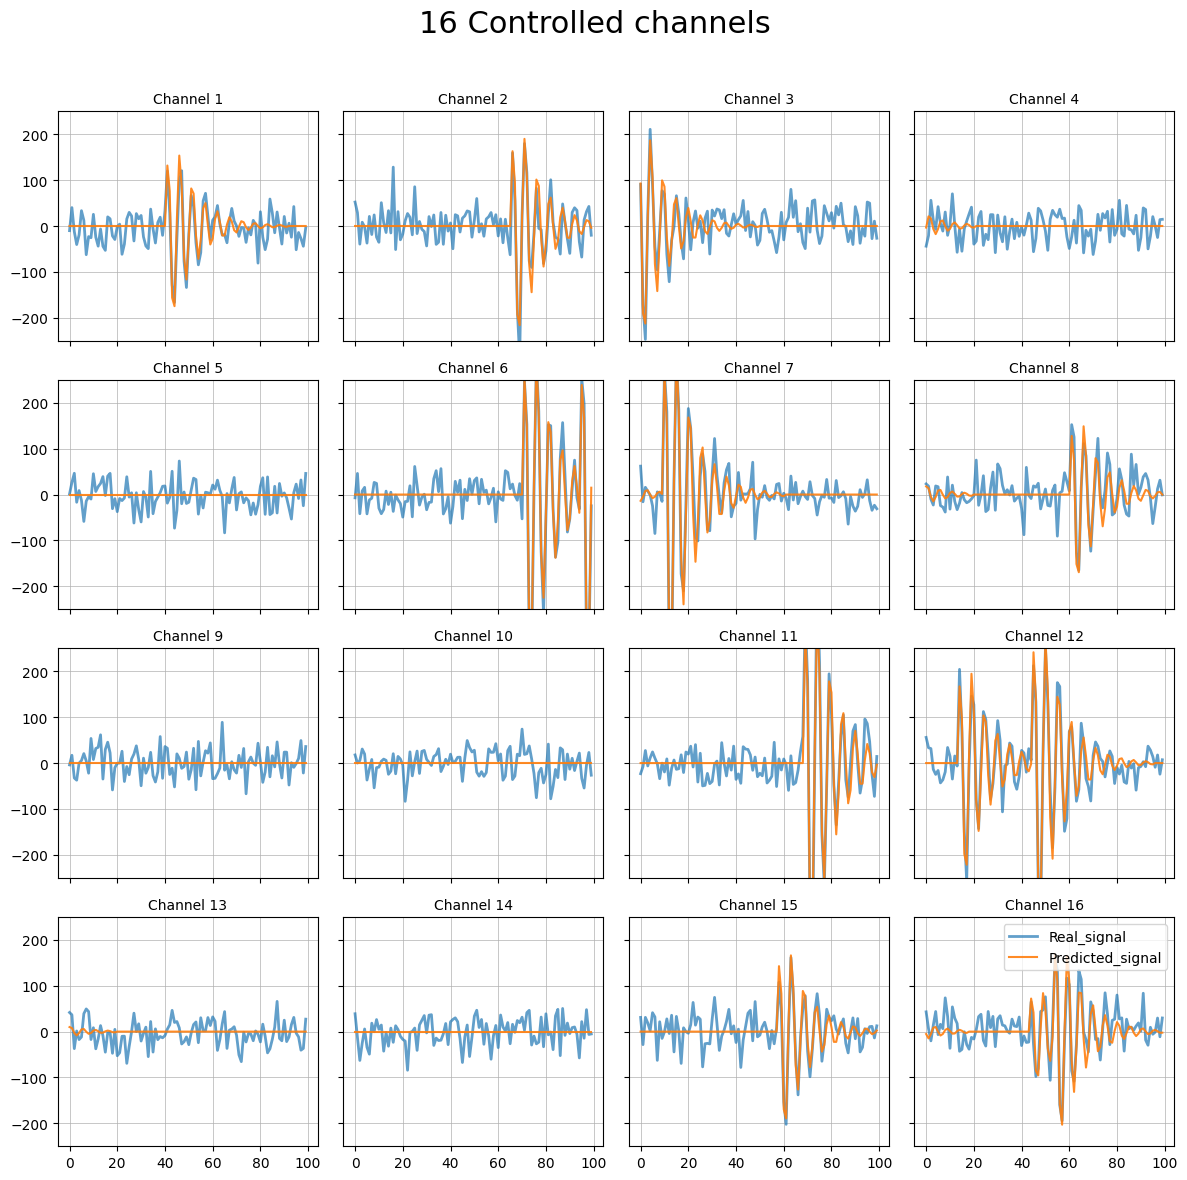

In [15]:
"""Defines a made up t_axis because it's easier than extracting the real time from the data"""

t_axis=np.arange(0,100,1)

#plots an example of the noisy and clean waveforms used for training
#change m to see other example plots. m is now set at 9
display_n_plots_format2(t_axis,N_Train_Data,16,9,C_Train_Real,1,1)
#display_n_plots_format2(t_axis,C_Train_Real,16,0)

In [108]:
"""normalize to go from 0 to 1"""

maxes=[]
maxes.append(np.max(np.abs(N_Train_Data)))
maxes.append(np.max(np.abs(C_Train_Real)))
maxes.append(np.max(np.abs(N_Test_Data)))
maxes.append(np.max(np.abs(C_Test_Real)))
max=np.max(maxes)
N_Train_Data=N_Train_Data/(2*max)+0.5
C_Train_Real=C_Train_Real/(2*max)+0.5
N_Test_Data=N_Test_Data/(2*max)+0.5
C_Test_Real=C_Test_Real/(2*max)+0.5
#our data is now normalized and between 0 and 1

input_shape=np.shape(N_Train_Data)
print(input_shape)


(128, 1000, 16)


In [109]:
"""Defining the CNN model"""
def build_denoising_model(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(1000, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    # Decoder
    model.add(layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(1000, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(input_shape[-1], kernel_size=3, activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [110]:

# Build and compile the model
model = build_denoising_model((1000,16))
model.summary()

/home/shams/.virtualenvs/Research with Dr Ilya/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_43 (Conv1D)              │ (None, 1000, 128)      │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 500, 1000)      │       385,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 250, 1000)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 250, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 125, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 125, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_16 (UpSampling1D) │ (None, 250, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 250, 1000)      │        49,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_17 (UpSampling1D) │ (None, 500, 1000)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 500, 128)       │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_18 (UpSampling1D) │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 1000, 16)       │         6,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 879,360 (3.35 MB)

 Trainable params: 879,360 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(N_Train_Data, C_Train_Real, test_size=0.1, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=1, validation_data=(X_val, y_val))

dict_keys(['loss', 'val_loss'])


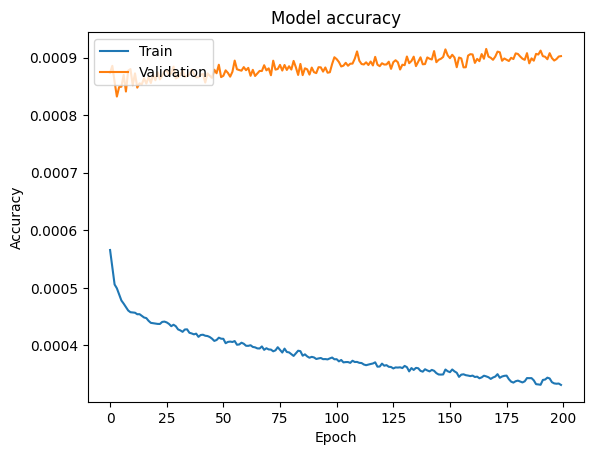

In [118]:
# Print the history keys
# Evaluate and Visualize the Results
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [120]:
#Train the new test data to see how model performs
#predict and rescale

#predict:
NC_Trained_Test = model.predict(N_Test_Data)
NC_Trained_Original= model.predict( N_Train_Data)

#rescale
NC_Trained_Test_resized = (NC_Trained_Test-0.5)*2*max
NC_Trained_Original_resized = (NC_Trained_Original-0.5)*2*max
C_Test_Real_resized=(C_Test_Real-0.5)*2*max


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


In [122]:
n_plots=5
for i in range(n_plots):
    display_n_plots_format2(t_axis,C_Test_Real_resized,16,i,NC_Trained_Test_resized,1,True)

--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------


<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [103]:
#If model performs well, It can be saved
model.save("Second_working_CNN.keras")